# Three Frame Difference

Implementation of the three frame difference algorithm on a sequence of frames

In [1]:
import numpy as np
import os
import imageio.v3 as iio
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [2]:
class ThreeFrameDiff:
    def __init__(self, base_dir, grayscale = True, frame_delta = 1, threshold=10):
        """
            Three Frame Difference.
            params:
            -------
                * base_dir : Base Directory containing the frame sequence.
                * grayscale : True/False
                * frame_delta : delta or difference of how many frames
                * threshold : threshold for difference in pixels
            returns:
            --------
                * Three Frame Difference Object
        """
        self.base_dir = base_dir
        self.frame_delta = frame_delta
        assert self.frame_delta >= 1
        
        self.threshold = threshold
        
        # Create & Store the figure to be updated
        self.__fig, self.__axes, self.__axes_ims = None, None, list()
        if grayscale == True:
            self.cmap = 'gray'
        else:
            self.cmap = "viridis"
        
        self.files = sorted(os.listdir(base_dir))
        self.frames = None
        plt.ion() # Enable Interactive Mode
    
    def __init_plot(self)->None:
        """
            Helper function initializing the plot displaying the frames
        """
        self.__fig, self.__axes = plt.subplots(nrows = 3, ncols = 3, figsize = (12, 6))
        plt.setp(self.__axes.flat, xticks = [], yticks = [])
        for i, ax in enumerate(self.__axes.flat):
            if i == 8 or i == 6:
                ax.set_visible(False)
            self.__axes_ims.append(ax.imshow(np.zeros(self.frames[0].shape), cmap = self.cmap, vmin=0, vmax=255))
        self.__fig.canvas.draw()
        display(self.__fig, clear=True)
    
    def __update_plot(self, image_arr, labels)->None:
        """
            Function to update the plot with new frames/ images
        """
        if(len(self.__axes.flat)-len(image_arr))>2:
            raise Exception("Plot Axes and Image Array don't conform.")
        if len(labels) != len(image_arr):
            raise Exception("Images & Labels not in equal sizes")
        for i, ax in enumerate(self.__axes.flat):
            if i == 6 or i ==8:
                continue
            if i == 7:
                # For masked images
                self.__axes_ims[i].set_data(image_arr[i-1])
                ax.set_title(labels[i-1])
                continue
            self.__axes_ims[i].set_data(image_arr[i])
            ax.set_title(labels[i])
        
        self.__fig.suptitle(f'Frame Difference: {self.frame_delta}, Threshold: {self.threshold}', fontsize=14)
        self.__fig.canvas.draw()
        self.__fig.canvas.flush_events()
        display(self.__fig, clear=True)
    
    def __get_frames(self):
        """
            Function to generate the frames from the provided base directory.
        """
        frames = []
        print("Generating Frames...")
        for file in self.files:
            frame = iio.imread(self.base_dir+file)
            if self.cmap == 'gray':
                frame = np.dot(frame, [0.2989, 0.5870, 0.1140])
                frame = np.round(frame).astype(np.short)
            frames.append(frame.astype(np.short))
        return frames
    
    def __apply_threshold(self, *args):
        """
            Apply the threshold on a given set of difference of frames.
        """
        res = []
        for arg in args:
            arg[arg<self.threshold] = 0
            arg[arg!=0] = 255
            res.append(arg)
        return res

    def run(self):
        # Generate the set of frames
        self.frames = self.__get_frames()
        zeros = np.zeros(self.frames[0].shape)
        
        # Initialize the plot
        self.__init_plot()
        
        for idx, frame in enumerate(self.frames):
            labels = ["Old Frame", f"Current Frame (idx={idx})", "Future Frame", "Current - Past", "Three Frame Diff", "Current - Future", "Masked Frame"]
            if idx<self.frame_delta:
                # Not enough frames to take difference from past frame
                d_fut = np.abs(frame - self.frames[idx+self.frame_delta])
                d_fut = self.__apply_threshold(d_fut)[0]
                img_arr = [frame, frame, self.frames[idx+self.frame_delta], zeros, zeros, d_fut, frame]
            elif idx>=(len(self.frames)-self.frame_delta):
                # Not enough frames to take difference from future frame
                d_past = np.abs(frame - self.frames[idx-self.frame_delta])
                d_past = self.__apply_threshold(d_past)[0]
                img_arr = [self.frames[idx-self.frame_delta], frame, frame, d_past, zeros, zeros, frame]
            else:
                d_past = np.abs(frame - self.frames[idx-self.frame_delta])
                d_fut = np.abs(frame - self.frames[idx+self.frame_delta])
                d_past, d_fut = self.__apply_threshold(d_past, d_fut)
                tracked_frame = np.logical_and(d_past, d_fut)
                mask = np.any(tracked_frame, axis=2)
                masked_frame = np.copy(frame)
                masked_frame[mask,:] = [255,0,0]
                tracked_frame = tracked_frame.astype(np.uint8)
                tracked_frame[tracked_frame!=0]=255
                img_arr = [self.frames[idx-self.frame_delta], frame, self.frames[idx+self.frame_delta], d_past, tracked_frame, d_fut, masked_frame]
            try:
                self.__update_plot(img_arr, labels)
            except Exception as e:
                raise(e)
        clear_output()

In [3]:
model = ThreeFrameDiff(base_dir="data/frame sequence/", frame_delta=8, threshold=25, grayscale=False)

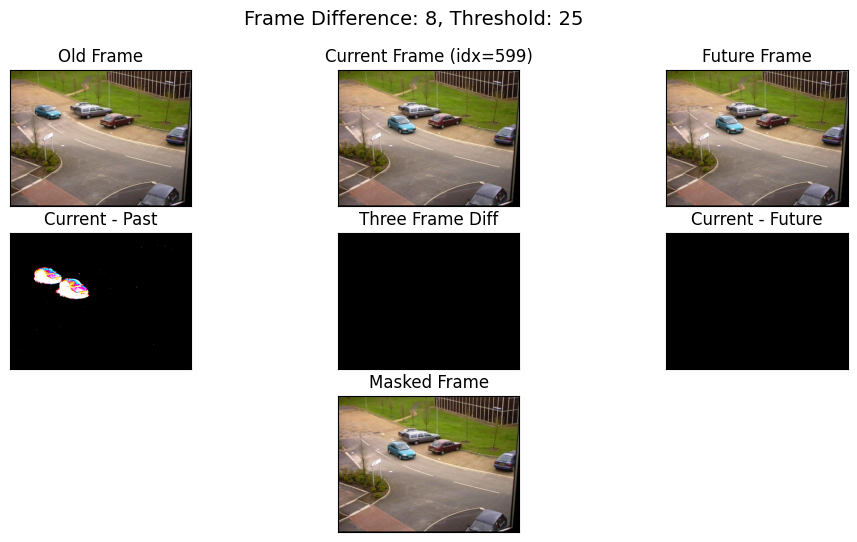

In [4]:
model.run()